# Part 3 : Deployment

Now, we have chosen and saved the model (**Simple_model**). Let's start for the deployment

## General preprocessing

### Import libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn library
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import joblib
import pickle

# import tensorflow and keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

### Set the GPU

In [2]:
# Test if the GPU will comput
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#Set the memory limit for the GPU otherwise it may be out of ressource et return an error
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 3GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
#Set the saveOption to local host otherwise the model may save into the GPU
localhost_save_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")

### Load the data

In [5]:
full_df=pd.read_pickle('../full_df.pkl')
full_df.head()

,ClassId,Path,Class
0,20,Train/20/00020_00000_00000.png,Dangerous curve right
1,20,Train/20/00020_00000_00001.png,Dangerous curve right
2,20,Train/20/00020_00000_00002.png,Dangerous curve right
3,20,Train/20/00020_00000_00003.png,Dangerous curve right
4,20,Train/20/00020_00000_00004.png,Dangerous curve right


In [6]:
full_df['Path']=full_df['Path'].apply(lambda x : f'../{x}')

### Define the classes

In [7]:
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

l_classes = list(classes.keys())
nb_classes = len(l_classes)

### Initialize the variables

In [8]:
# Target size of each image
width_im = 50
height_im = 50
image_size = (width_im, height_im)

# Size of the batch
batch_size = 16

### Set the features/target

In [9]:
#set the features
X=full_df['Path']
# Set the target
label_cat=to_categorical(full_df['ClassId'],num_classes=nb_classes)

In [10]:
label_cat[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Deployment Simple_model 

In [11]:
def im2array(path):
    path=path
    img = image.load_img(path, target_size=image_size) #load and resize
    x = image.img_to_array(img) #Value rgb between 0 and 255
    return list(x/255.0)

In [12]:
n_model='Simple_model'
model = Sequential()
model.add(layers.Conv2D(48, (3, 3), activation='relu', input_shape=(width_im, height_im, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(nb_classes,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        27712     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 5184)              0

In [13]:
class preprocessor(TransformerMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, paths):
        return np.array([im2array(path) for path in list(paths)])

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
pipe=make_pipeline(preprocessor(),model)
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor', preprocessor()),
                ('sequential',
                 <keras.engine.sequential.Sequential object at 0x0000016A76066070>)])>

In [15]:
%%time
pipe.fit(full_df['Path'],
         label_cat,
         sequential__epochs=50,
         sequential__validation_split=0.1)

Epoch 1/50
1458/1458 [==============================] - 13s 5ms/step - loss: 0.9805 - accuracy: 0.7290 - val_loss: 0.2548 - val_accuracy: 0.9290
Epoch 2/50
1458/1458 [==============================] - 7s 5ms/step - loss: 0.1372 - accuracy: 0.9639 - val_loss: 0.1410 - val_accuracy: 0.9597
Epoch 3/50
1458/1458 [==============================] - 7s 5ms/step - loss: 0.0671 - accuracy: 0.9812 - val_loss: 0.1154 - val_accuracy: 0.9718
Epoch 4/50
1458/1458 [==============================] - 7s 5ms/step - loss: 0.0480 - accuracy: 0.9857 - val_loss: 0.0779 - val_accuracy: 0.9786
Epoch 5/50
1458/1458 [==============================] - 7s 5ms/step - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.0904 - val_accuracy: 0.9796
Epoch 6/50
1458/1458 [==============================] - 7s 5ms/step - loss: 0.0232 - accuracy: 0.9932 - val_loss: 0.0940 - val_accuracy: 0.9817
Epoch 7/50
1458/1458 [==============================] - 8s 5ms/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.0783 - val_accuracy

Pipeline(steps=[('preprocessor', preprocessor()),
                ('sequential',
                 <keras.engine.sequential.Sequential object at 0x0000016A76066070>)])

In [16]:
x=full_df['Path'].sample().values[0]
x

'../Train/13/00013_00061_00003.png'

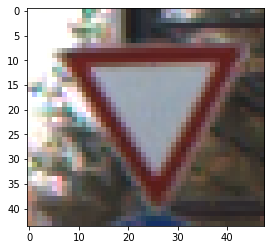

In [17]:
plt.imshow(plt.imread(x))
plt.show()

In [18]:
pred=pipe.predict(pd.Series(x)).argmax(axis=-1)[0]
classes[pred]

1/1 [==============================] - 0s 396ms/step


'Yield'

In [19]:
# Save the CNN model
pipe[-1].save('./Model/Simple_model.h5',options=localhost_save_option)

# Save the rest of the Pipeline
with open(r'./Model/pipeline.joblib','wb') as file :
    joblib.dump(pipe[:-1],file)

------------------------

In [20]:
#Load the pipeline (without the model)
with open(r'./Model/pipeline.joblib','rb') as file :
    new_pipeline = joblib.load(file)

#Load the model
new_model=load_model('./Model/Simple_model.h5',options=localhost_save_option)

#Append the model to the pipeline
new_pipeline.steps.append(['sequential',new_model])

# Check the pipeline
new_pipeline.steps

[('preprocessor', preprocessor()),
 ['sequential', <keras.engine.sequential.Sequential at 0x16b0a8b27f0>]]

In [21]:
#make some prediction
new_pred=new_pipeline.predict(pd.Series(x)).argmax(axis=-1)[0]
classes[new_pred]

1/1 [==============================] - 0s 120ms/step


'Yield'

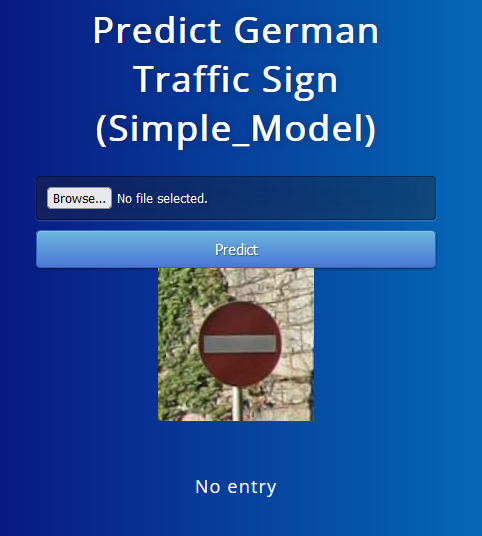